# Water Analyses 

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr  

In [2]:
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')

platform = "LANDSAT_7"
product = "ls7_ledaps_tanzania" 

# Get Coordinates
coordinates = api.get_full_dataset_extent(platform = platform, product = product)

time_extents = (min(coordinates['time'].values),max(coordinates['time'].values))
print( time_extents )

latitude_extents = (min(coordinates['latitude'].values),max(coordinates['latitude'].values))
print( latitude_extents )

longitude_extents = (min(coordinates['longitude'].values),max(coordinates['longitude'].values))
print( longitude_extents )

(numpy.datetime64('2000-01-06T07:25:39.000000000'), numpy.datetime64('2018-01-01T08:10:04.000000000'))
(-11.999019059879926, -0.0001356388440351325)
(28.998784571651935, 40.99806659404953)


# Visualize Data Cube Region and Select an Analysis Region

In [3]:
## The code below renders a map that can be used to orient yourself with the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extents, longitude = longitude_extents)

In [4]:
# Lake Sulunga - Tanzania
latitude_extents =  (-6.3605, -5.8252) 
longitude_extents =  (34.9756, 35.4535)
time_extents = ('2015-01-01', '2018-01-01')

In [5]:
display_map(latitude = latitude_extents, longitude = longitude_extents)

## Load the dataset and the required spectral bands or other parameters
After loading, you will view the Xarray dataset. Notice the dimensions represent the number of pixels in your latitude and longitude dimension as well as the number of time slices (time) in your time series.

In [6]:
%%time
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

CPU times: user 1min 3s, sys: 8.71 s, total: 1min 12s
Wall time: 3min 14s


In [7]:
print(landsat_dataset)
#view the dimensions and sample content from the cube

<xarray.Dataset>
Dimensions:    (latitude: 1974, longitude: 1764, time: 138)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-04T07:49:05 ... 2017-12-27T07:52:47
  * latitude   (latitude) float64 -5.825 -5.826 -5.826 ... -6.36 -6.36 -6.361
  * longitude  (longitude) float64 34.98 34.98 34.98 34.98 ... 35.45 35.45 35.45
Data variables:
    red        (time, latitude, longitude) int16 835 767 732 ... -9999 -9999
    green      (time, latitude, longitude) int16 791 791 773 ... -9999 -9999
    blue       (time, latitude, longitude) int16 563 512 545 ... -9999 -9999
    nir        (time, latitude, longitude) int16 2585 2622 2696 ... -9999 -9999
    swir1      (time, latitude, longitude) int16 1773 1661 1750 ... -9999 -9999
    swir2      (time, latitude, longitude) int16 994 925 948 ... -9999 -9999
    pixel_qa   (time, latitude, longitude) int32 66 66 66 72 72 72 ... 1 1 1 1 1
Attributes:
    crs:      EPSG:4326


>### Masking out Clouds

In [8]:
cloud_mask = np.bitwise_and(landsat_dataset.pixel_qa,6).astype(bool)
cleaned_dataset = landsat_dataset.drop('pixel_qa').where(cloud_mask)

## Time Series Water Detection Analysis
Time series output of the Australian Water Detection from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

In [9]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
ts_water_classification = wofs_classify(landsat_dataset,clean_mask = cloud_mask)

In [10]:
# Apply nan to no_data values
ts_water_classification = ts_water_classification.where(ts_water_classification != -9999).astype(np.float16)

##Time series aggregation that ignores nan values.    
water_classification_percentages = (ts_water_classification.mean(dim = ['time']) * 100).wofs.rename('water_classification_percentages')

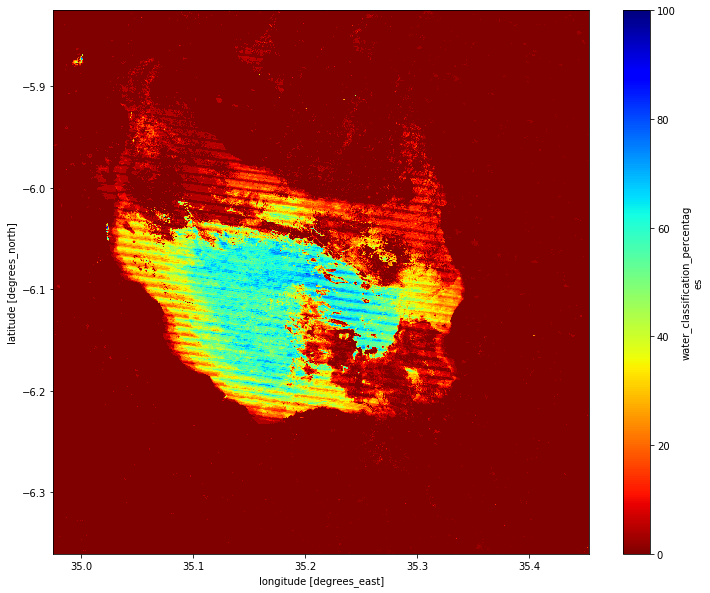

In [11]:
## import color-scheme and set nans to black
from matplotlib.cm import jet_r as jet_r
jet_r.set_bad('black',1)

water_classification_percentages.plot(cmap = jet_r, figsize=(12,10))

In [12]:
# # Save the water percentage data to a GeoTIFF
# from utils.data_cube_utilities.import_export import export_slice_to_geotiff

# dataset_to_export = xr.Dataset(coords=ts_water_classification.coords,attrs=ts_water_classification.attrs)
# dataset_to_export['wofs_pct'] = (water_classification_percentages/100).astype(np.float32)
# print(dataset_to_export)

# The export command on the following line is commented out to avoid overwriting files. 
# If you would like to export data, please change the filename before uncommenting the next line.

#export_slice_to_geotiff(dataset_to_export, 'geotiffs/WOfS_Percentage-Sulunga.tif')

ImportError: No module named 'utils.data_cube_utilities.import_export'

The following code computes and then plots the percentage of valid pixels that were identified as water, for each time step in the time series.

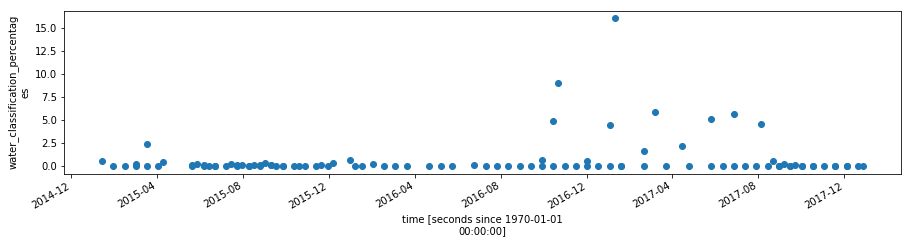

In [13]:
water_classification_percentages = (ts_water_classification.mean(dim = ['latitude','longitude']) * 100).wofs.rename('water_classification_percentages')
water_classification_percentages.plot(figsize=(15,3), marker='o', linestyle='None')

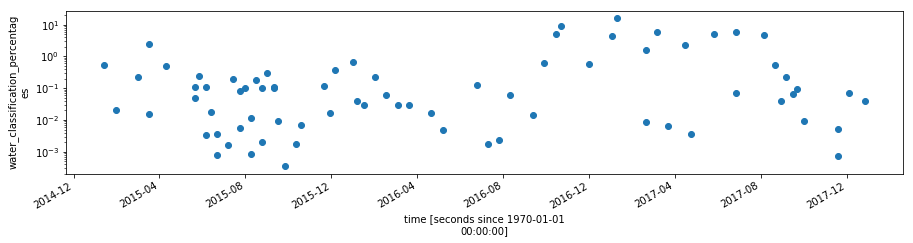

In [14]:
water_classification_percentages.plot(figsize=(15,3), marker='o', linestyle='None')
plt.gca().set_yscale('log') # Change scaling of the Y axis to logarithmic